# Lab 6 - Recurent Neural Network LSTM GRU
*by Yurii Voievidka* (Not only)

Import libraries

https://www.kaggle.com/code/raoulma/ny-stock-price-prediction-rnn-lstm-gru/notebook

https://www.kaggle.com/code/charel/learn-by-example-rnn-lstm-gru-time-series

In [39]:
import pandas as pd
import numpy as np
from numpy import newaxis
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM, GRU

valid_set_size_percentage = 10 
test_set_size_percentage = 10
Enrol_window = 100

In [21]:
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


In [37]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 

Load data

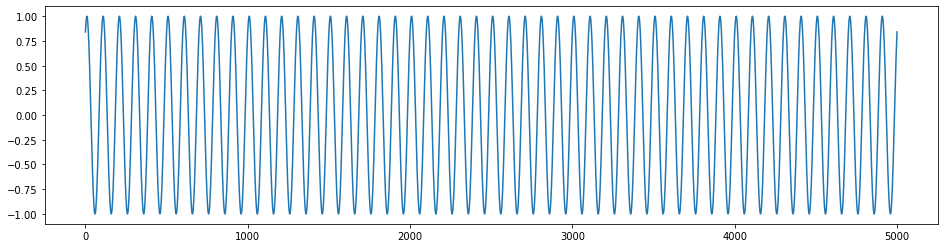

In [17]:
dataset = pd.read_csv('./drive/MyDrive/Sin Wave Data Generator.csv')
dataset["Wave"][:].plot(figsize=(16,4), legend=False)

In [23]:
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', Enrol_window, False)

In [32]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print('model compiled')

print(model.summary())

model compiled
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))

Epoch 1/10
9/9 [==============================] - 17s 1s/step - loss: 0.2774 - val_loss: 0.1046
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.0459 - val_loss: 0.0061
Epoch 3/10
9/9 [==============================] - 9s 1s/step - loss: 0.0138 - val_loss: 0.0061
Epoch 4/10
9/9 [==============================] - 9s 1s/step - loss: 0.0089 - val_loss: 0.0028
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.0057 - val_loss: 7.3655e-04
Epoch 6/10
9/9 [==============================] - 9s 1s/step - loss: 0.0052 - val_loss: 7.7400e-04
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.0044 - val_loss: 4.6959e-04
Epoch 8/10
9/9 [==============================] - 9s 1s/step - loss: 0.0041 - val_loss: 2.4363e-04
Epoch 9/10
9/9 [==============================] - 11s 1s/step - loss: 0.0039 - val_loss: 2.0277e-04
Epoch 10/10
9/9 [==============================] - 9s 1s/step - loss: 0.0037 - val_loss: 2.3233e-04


1/1 [==============================] - 0s 28ms/step


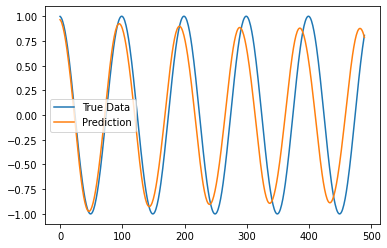

In [40]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, Enrol_window)
plot_results(predictions,label_test)

In [4]:
df = pd.read_csv('./drive/MyDrive/prices-split-adjusted.csv', index_col=0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 68484 entries, 2016-01-05 to 2010-08-02
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  68484 non-null  object 
 1   open    68484 non-null  float64
 2   close   68483 non-null  float64
 3   low     68483 non-null  float64
 4   high    68483 non-null  float64
 5   volume  68483 non-null  float64
dtypes: float64(5), object(1)
memory usage: 3.7+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [5]:
df.tail()

,symbol,open,close,low,high,volume
date,,,,,,
2010-08-02,NDAQ,19.719999,20.100000,19.490000,20.160000,2490900.0
2010-08-02,NEE,52.599998,54.009998,52.599998,54.009998,1992300.0
2010-08-02,NEM,56.860001,55.599998,54.980000,56.880001,6434700.0
2010-08-02,NFLX,14.860000,14.554286,14.424286,15.000000,24295600.0
2010-08-02,NFX,54.849990,NaN,NaN,NaN,NaN


In [6]:
df.describe()

,open,close,low,high,volume
count,68484.000000,68483.000000,68483.000000,68483.000000,6.848300e+04
mean,39.917798,39.919227,39.382886,40.406403,7.749396e+06
std,32.820608,32.806343,32.390147,33.203241,1.756624e+07
min,3.680000,3.680000,3.650000,3.740000,0.000000e+00
25%,21.529375,21.530001,21.219999,21.809999,1.633500e+06
50%,32.610001,32.630001,32.174999,33.020000,3.447300e+06
75%,48.389999,48.430000,47.790001,48.990002,7.233300e+06
max,385.089996,388.010010,378.809998,393.920013,5.890618e+08


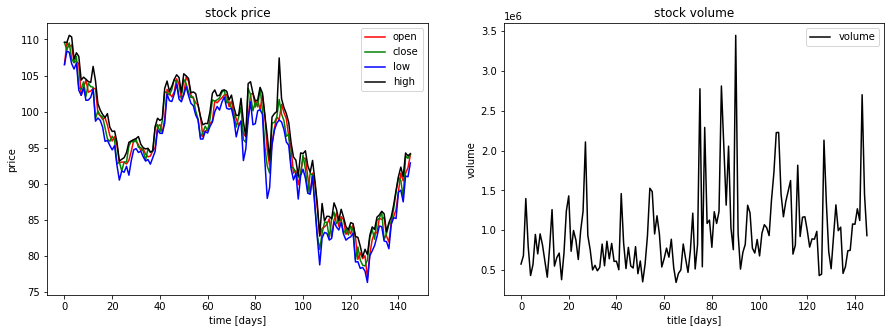

In [7]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('title [days]')
plt.ylabel('volume')
plt.legend(loc='best')

In [15]:
def normalize_data(df):
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
  df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
  df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
  df['close'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
  return df

def load_data(stock, seq_len):
  data_raw = stock.values
  data = []

  #create all possible sequenves of length seq_len
  for index in range(len(data_raw) - seq_len):
    data.append(data_raw[index:index + seq_len])

  data = np.array(data)
  valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]))
  test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
  train_set_size = data.shape[0] - (valid_set_size + test_set_size)

  x_train = data[:train_set_size,:-1,:]
  y_train = data[:train_set_size, -1,:]

  x_valid = data[train_set_size: train_set_size+valid_set_size,:-1,:]
  y_valid = data[train_set_size: train_set_size+valid_set_size,-1,:]

  x_test = data[train_set_size+valid_set_size:,:-1,:]
  y_test = data[train_set_size+valid_set_size:,-1,:]

  return [x_train, y_train, x_valid, y_valid, x_test, y_test]

df_stock = df[df.symbol == 'EQIX'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
print('df_stock.columns.values=',cols)

#normilize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

NameError: ignored

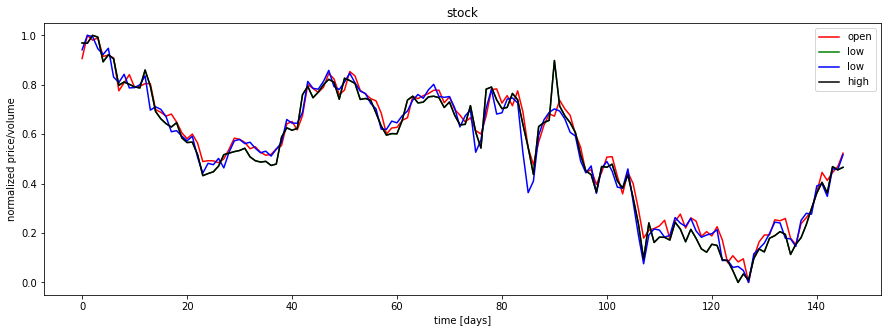

In [9]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

Modeling and Data Validation

In [10]:
index_in_epoch = 0
perm_array = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

In [11]:
def get_next_batch(batch_size):
  global index_in_epoch, x_train, perm_array
  start = index_in_epoch
  index_in_epoch += batch_size

  if index_in_epoch > x_train.shape[0]:
    np.random.shuffle(perm_array)
    start = 0
    index_in_epoch = batch_size

  end = index_in_epoch
  return x_train[perm_array[start:end]] , y_train[perm_array[start:end]]


# parameters
n_steps = seq_len-1
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

In [13]:
tf.compat.v1.reset_default_graph()

In [29]:
tf.compat.v1.disable_eager_execution()

In [30]:
X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

In [31]:
# Use basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation='elu') for layer in range(n_layers)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
  


In [32]:
# Use Basic LSTM Cell
# layers = [tf.compat.v1.nn.rnn_cell.BasicSTMCell(num_units=n_neurons, activation='elu') for layer in range(n_layers)]

In [33]:
# Use LSTM Cell with peephole connections
# layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation='elu', use_peepholes=True) for layer in range(n_layers)]

In [34]:
# Use GRU cell
# layers = tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation='elu', use_peepholes=True) for layer in range(n_layers)]

In [35]:
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)

In [36]:
multi_layer_cell = tf.keras.layers.StackedRNNCells(layers)

In [54]:
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [59]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps-1,:]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  


In [63]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate)
training_op = optimizer.minimize(loss)

In [74]:
#run graph
with tf.compat.v1.Session() as sess:
  sess.run(tf.compat.v1.global_variables_initializer())
  for iteration in range(int(n_epochs*train_set_size/batch_size)):
    x_batch, y_batch = get_next_batch(batch_size) 
    sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
    if iteration % int(5*train_set_size/batch_size) == 0:
      mse_train = loss.eval(feed_dict={X: x_train, y: y_train})
      mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid})
      print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(iteration*batch_size/train_set_size, mse_train, mse_valid))

  y_train_pred = sess.run(outputs, feed_dict={X: x_train})
  y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
  y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.290541/0.192276
5.00 epochs: MSE train/valid = 0.015363/0.023394
10.00 epochs: MSE train/valid = 0.011408/0.024217
15.00 epochs: MSE train/valid = 0.006679/0.009165
20.00 epochs: MSE train/valid = 0.005719/0.008403
25.00 epochs: MSE train/valid = 0.004772/0.007692
30.00 epochs: MSE train/valid = 0.004255/0.006075
35.00 epochs: MSE train/valid = 0.004020/0.005366
40.00 epochs: MSE train/valid = 0.003803/0.005366
45.00 epochs: MSE train/valid = 0.003588/0.005592
50.00 epochs: MSE train/valid = 0.003721/0.006432
55.00 epochs: MSE train/valid = 0.003240/0.005280
60.00 epochs: MSE train/valid = 0.003202/0.005730
65.00 epochs: MSE train/valid = 0.003032/0.005619
70.00 epochs: MSE train/valid = 0.003012/0.004398
75.00 epochs: MSE train/valid = 0.003602/0.003642
80.00 epochs: MSE train/valid = 0.003653/0.006144
85.00 epochs: MSE train/valid = 0.003635/0.005999
90.00 epochs: MSE train/valid = 0.003269/0.005532
95.00 epochs: MSE train/valid = 0.002989/0.005332


correct sign prediction for close - open price for train/valid/test: 0.73/0.62/0.62


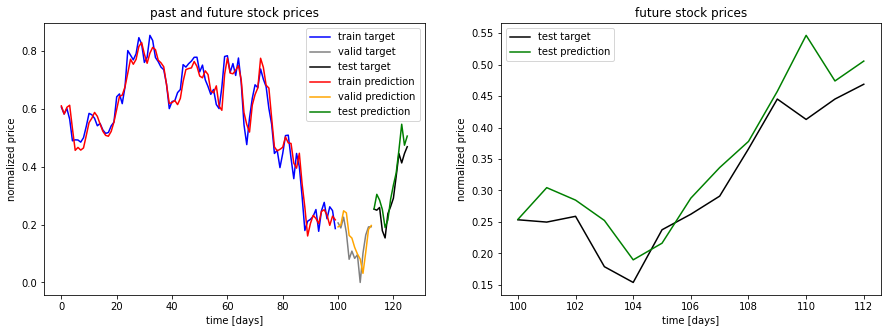

In [75]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest
## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft], color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]), y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]), y_valid_pred[:,ft], color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft], color='green', label='test prediction')
plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');
plt.subplot(1,2,2);
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]), y_test[:,ft], color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]), y_test_pred[:,ft], color='green', label='test prediction')
plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');
corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]), np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]), np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]), np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]
print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
corr_price_development_train, corr_price_development_valid, corr_price_development_test))

## SIMPLE LSTM (Not Outdated)

Importing Libraries

In [6]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from gensim.models import KeyedVectors


Defining Constants

In [2]:
EMBEDDING_FILES = [
    '../input/gensim-embeddings-dataset/crawl-300d-2M.gensim',
    '../input/gensim-embeddings-dataset/glove.840B.300d.gensim'
]
NUM_MODELS = 2
BATCH_SIZE = 512
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 4
MAX_LEN = 220
IDENTITY_COLUMNS = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
]
AUX_COLUMNS = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'
CHARS_TO_REMOVE = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n“”’\'∞θ÷α•à−β∅³π‘₹´°£€\×™√²—'


Build a matrix

In [3]:
def built_matrix(word_index, path):
  embedding_index = KeyedVectors.load(path, mmap='r')
  embedding_matrix = np.zeros(len(word_index) + 1, 300)
  for word, i in word_index.items():
        for candidate in [word, word.lower()]:
            if candidate in embedding_index:
                embedding_matrix[i] = embedding_index[candidate]
                break
  return embedding_matrix

Read Data

In [11]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

Build a model

In [14]:
def build_model(embedding_matrix, num_aux_targets):
    words = Input(shape=(None,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)

    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    aux_result = Dense(num_aux_targets, activation='sigmoid')(hidden)
    
    model = Model(inputs=words, outputs=[result, aux_result])
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model



x_train = train_df[TEXT_COLUMN].astype(str)
y_train = train_df[TARGET_COLUMN].values
y_aux_train = train_df[AUX_COLUMNS].values
x_test = test_df[TEXT_COLUMN].astype(str)

for column in IDENTITY_COLUMNS + [TARGET_COLUMN]:
    train_df[column] = np.where(train_df[column] >= 0.5, True, False)

tokenizer = text.Tokenizer(filters=CHARS_TO_REMOVE, lower=False)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = pad_sequences(x_train, maxlen=MAX_LEN)
x_test = pad_sequences(x_test, maxlen=MAX_LEN)

sample_weights = np.ones(len(x_train), dtype=np.float32)
sample_weights += train_df[IDENTITY_COLUMNS].sum(axis=1)
sample_weights += train_df[TARGET_COLUMN] * (~train_df[IDENTITY_COLUMNS]).sum(axis=1)
sample_weights += (~train_df[TARGET_COLUMN]) * train_df[IDENTITY_COLUMNS].sum(axis=1) * 5
sample_weights /= sample_weights.mean()

embedding_matrix = np.concatenate([built_matrix(tokenizer.word_index, y_train.shape) for f in EMBEDDING_FILES], axis=-1)

checkpoint_predictions = []
weights = []

for model_idx in range(NUM_MODELS):
    model = build_model(embedding_matrix, y_aux_train.shape[-1])
    for global_epoch in range(EPOCHS):
        model.fit(
            x_train,
            [y_train, y_aux_train],
            batch_size=BATCH_SIZE,
            epochs=1,
            verbose=2,
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)]
        )
        checkpoint_predictions.append(model.predict(x_test, batch_size=2048)[0].flatten())
        weights.append(2 ** global_epoch)

predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'prediction': predictions
})
submission.to_csv('submission.csv', index=False)


AttributeError: ignored